# Analýza shromážděných účastnických dat pro AmKon 2023 prostřednictvím systému AmKonApp
*autor: Martin Gráf*

*\*K analýze byla využita data z databáze AmKonApp k datu 17.9.2023.*

In [154]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import plotly.graph_objects as gp

In [155]:
def removeSensitiveColumns(d: pd.DataFrame):
    d.drop('Číslo průkazu',axis='columns', inplace=True, errors='ignore')

In [156]:
def removeAdminsAndOrgs(d: pd.DataFrame) -> pd.DataFrame:
    attendees = d.loc[d['Přístupová práva'].isin(['Účastník', 'Přihlášený'])]
    # loggedIn = d[d['Přístupová práva'] == ]
    return attendees

In [157]:
def constructRegistrationsWithUserFields(users: pd.DataFrame, registrations: pd.DataFrame) -> pd.DataFrame:
    amendedRegistrations = registrations
    amendedRegistrations['Pohlaví'] = 'Jiné'
    for reg in amendedRegistrations.index:
        currentItem = amendedRegistrations.loc[reg]
        correspondingUser = users.loc[users['Id'] == currentItem['Id']].iloc[0]
        amendedRegistrations.at[reg, 'Pohlaví'] = correspondingUser['Pohlaví']
    return amendedRegistrations

In [158]:
def constructPyramidPercentDataframe(originData: pd.DataFrame, categories: list, categoricalColumn: str, binaryColumn: str, binary1: str, binary2: str) -> pd.DataFrame:
    set1 = originData[originData[binaryColumn] == binary1]
    set2 = originData[originData[binaryColumn] == binary2]
    distribution = pd.DataFrame({categoricalColumn: categories, 
                                    binary1: [set1[set1[categoricalColumn] == i].shape[0] for i in categories],
                                    binary2: [set2[set2[categoricalColumn] == i].shape[0] for i in categories]})
    sum2 = distribution[binary2].sum()
    sum1 = distribution[binary1].sum()
    if sum2 > 0:
        set2Percent = 100/sum2
    else:
        set2Percent = 1

    if sum1 > 0:
        set1Percent = 100/sum1
    else:
        set1Percent = 1

    for i in range(len(distribution)):
        distribution[binary1][i] = distribution[binary1][i]*set1Percent
        distribution[binary2][i] = distribution[binary2][i]*set2Percent
    distribution[binary2] = distribution[binary2] * (-1)
    return distribution

In [159]:
users = pd.read_csv('data/2023/export.csv')
registrations = pd.read_csv('data/2023/registrace.csv')
transactions = pd.read_csv('data/2023/transakce.csv')

warnings.simplefilter(action='ignore', category=FutureWarning)

In [160]:
genders = ['Muž', 'Žena', 'Jiné']
schoolVals = ['2. ročník SŠ a nižší', '3. ročník SŠ', '4. ročník SŠ', 'bakalářské studium', 'magisterské studium']
congressBodies = ['Government', 'TCK', 'Lobby', 'Senate', 'House']

Z celkem 139 přijatých účastníků bylo 90 mužů a 48 žen, spolu s 1 příslušníkem jiného pohlaví.


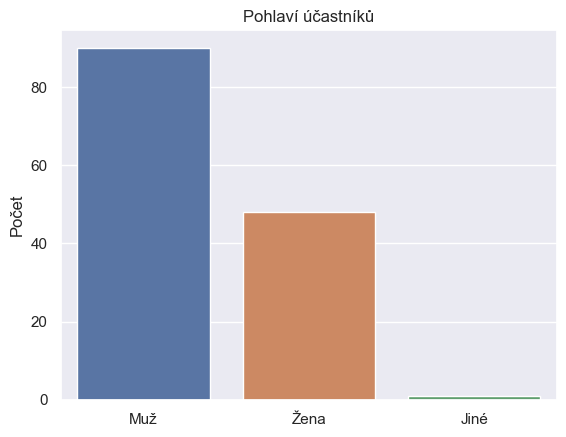

In [161]:
removeSensitiveColumns(users)
nonOrgs = removeAdminsAndOrgs(users)
sns.set(font_scale=1)
user_hist = sns.countplot(x=nonOrgs['Pohlaví'], data=nonOrgs, order=genders)
print('Z celkem {} přijatých účastníků bylo {} mužů a {} žen, spolu s {} příslušníkem jiného pohlaví.'
      .format(nonOrgs[nonOrgs['Pohlaví'].isin(genders)].shape[0], nonOrgs[nonOrgs['Pohlaví'] == 'Muž'].shape[0], nonOrgs[nonOrgs['Pohlaví'] == 'Žena'].shape[0], 
              nonOrgs[nonOrgs['Pohlaví'] == 'Jiné'].shape[0]))
plt.title('Pohlaví účastníků')
plt.ylabel('Počet')
plt.xlabel('')
plt.show(user_hist)


Vzhledem k minimálnímu množství příslušníků jiného pohlaví budou vynecháni při porovnávání vlastností jednotlivých skupin podle pohlaví, budou ovšem zahrnuti v jiných metrikách.

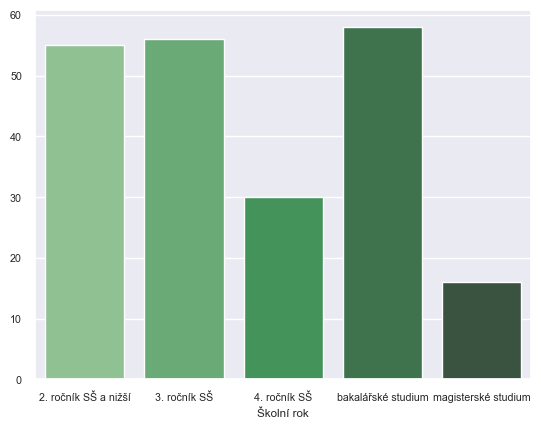

In [162]:
pairedRegs = constructRegistrationsWithUserFields(users=nonOrgs, registrations=registrations)
sns.set(font_scale=0.7)
fig = sns.countplot(x=pairedRegs['Školní rok'], order=schoolVals, data=pairedRegs, palette="Greens_d")
plt.ylabel("")
plt.show(fig)

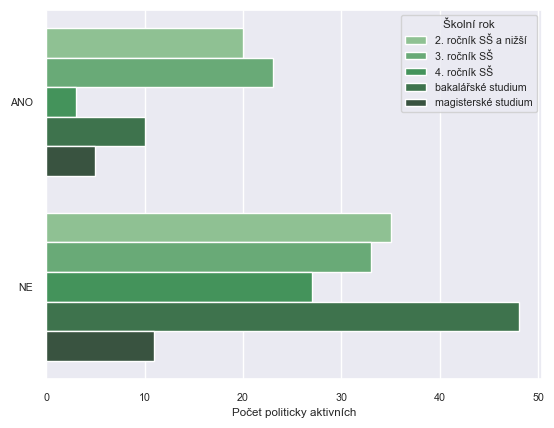

In [163]:
fig = sns.countplot(y=pairedRegs['Člen politické strany'], data=pairedRegs, hue=pairedRegs['Školní rok'], hue_order=schoolVals, palette="Greens_d")
plt.ylabel("")
plt.xlabel("Počet politicky aktivních")
plt.show(fig)

In [164]:
schoolDistribution = constructPyramidPercentDataframe(originData=pairedRegs, categories=schoolVals, categoricalColumn='Školní rok', binaryColumn='Pohlaví', binary1='Muž', binary2='Žena')

C:\Users\margr\AppData\Local\Temp\ipykernel_18040\2371379105.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\margr\AppData\Local\Temp\ipykernel_18040\2371379105.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [165]:
fig = gp.Figure()

fig.add_trace(gp.Bar(y= schoolDistribution['Školní rok'], x = schoolDistribution['Muž'], 
                     name = 'Muži', 
                     orientation = 'h'))

fig.add_trace(gp.Bar(y = schoolDistribution['Školní rok'], x = schoolDistribution['Žena'],
                     name = 'Ženy', orientation = 'h'))

fig.update_layout(title = 'Rozdělení vzdělání podle pohlaví',
                 title_font_size = 22, barmode = 'relative',
                 bargap = 0.0, bargroupgap = 0,
                 xaxis = dict(tickvals = [-30, -20, -10,
                                          0, 10, 20, 30],
                                
                              ticktext = ['30%', '20%', '10%', '0%', 
                                          '10%', '20%', '30%'],
                                
                              title_font_size = 14)
                 )
  
fig.show()

In [166]:
schoolPoliticsDistribution = constructPyramidPercentDataframe(originData=pairedRegs, categories=genders, categoricalColumn='Pohlaví', binaryColumn='Člen politické strany', binary1='ANO', binary2='NE')

C:\Users\margr\AppData\Local\Temp\ipykernel_18040\2371379105.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\margr\AppData\Local\Temp\ipykernel_18040\2371379105.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [167]:
fig = gp.Figure()
fig.add_trace(gp.Bar(y= schoolPoliticsDistribution['Pohlaví'], x = schoolPoliticsDistribution['ANO'], 
                     name = 'Politicky aktivní', 
                     orientation = 'h'))
fig.add_trace(gp.Bar(y = schoolPoliticsDistribution['Pohlaví'], x = schoolPoliticsDistribution['NE'],
                     name = 'Politicky neaktivní', orientation = 'h'))
fig.update_layout(title = 'Rozdělení pohlaví podle členství v politických stranách',
                 title_font_size = 22, barmode = 'relative',
                 bargap = 0.0, bargroupgap = 0,
                 xaxis = dict(tickvals = [-80, -60, -30, -10,
                                          0, 10, 30, 60, 80],
                                
                              ticktext = ['80%', '60%', '30%', '10%', '0%', 
                                          '10%', '30%', '60%', '80%'],
                                
                              title_font_size = 14)
                 )
fig.show()

In [168]:
preferenceDistribution = constructPyramidPercentDataframe(originData=pairedRegs, categories=congressBodies, categoricalColumn='Preferovaná odnož', binaryColumn='Pohlaví', binary1='Muž', binary2='Žena')

C:\Users\margr\AppData\Local\Temp\ipykernel_18040\2371379105.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\margr\AppData\Local\Temp\ipykernel_18040\2371379105.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [169]:
fig = gp.Figure()
fig.add_trace(gp.Bar(y= preferenceDistribution['Preferovaná odnož'], x = preferenceDistribution['Muž'], 
                     name = 'Muži', 
                     orientation = 'h'))
fig.add_trace(gp.Bar(y = preferenceDistribution['Preferovaná odnož'], x = preferenceDistribution['Žena'],
                     name = 'Ženy', orientation = 'h'))
fig.update_layout(title = 'Rozdělení preferencí podle pohlaví',
                 title_font_size = 22, barmode = 'relative',
                 bargap = 0.0, bargroupgap = 0,
                 xaxis = dict(tickvals = [-30, -20, -10,
                                          0, 10, 20, 30],
                              ticktext = ['30%', '20%', '10%', '0%', 
                                          '10%', '20%', '30%'],
                              title_font_size = 14)
                 )
fig.show()

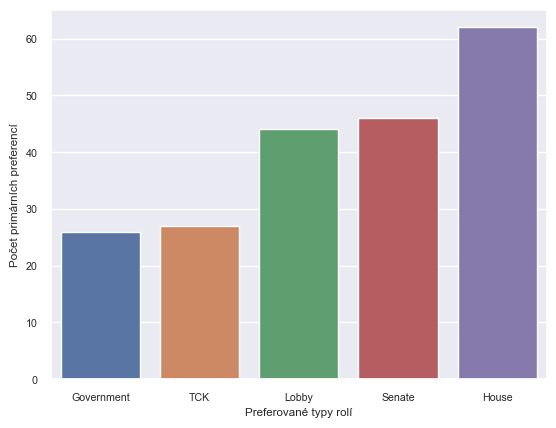

In [174]:
sns.set(font_scale=0.7)
fig = sns.countplot(x=pairedRegs['Preferovaná odnož'], order=congressBodies, data=pairedRegs)
plt.ylabel("Počet primárních preferencí")
plt.xlabel("Preferované typy rolí")
plt.show(fig)

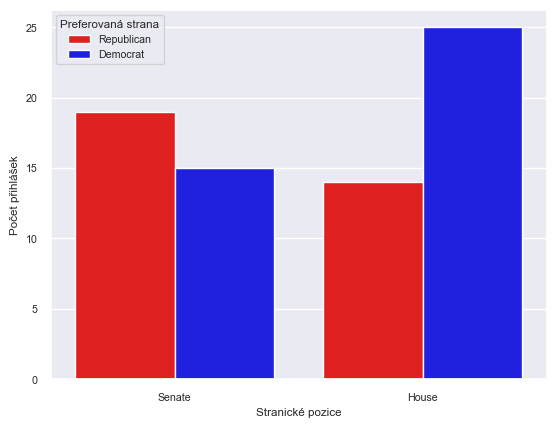

In [182]:
partisianPreferences = pairedRegs[pairedRegs['Preferovaná odnož'].isin(['House', 'Senate'])]
fig = sns.countplot(x=partisianPreferences['Preferovaná odnož'], data=partisianPreferences, hue=partisianPreferences['Preferovaná strana'], palette=['Red','Blue'])
plt.ylabel("Počet přihlášek")
plt.xlabel("Stranické pozice")
plt.show(fig)

In [186]:
partisianDistribution = constructPyramidPercentDataframe(originData=pairedRegs, categories=genders, categoricalColumn='Pohlaví', binaryColumn='Preferovaná strana', binary1='Republican', binary2='Democrat')

C:\Users\margr\AppData\Local\Temp\ipykernel_18040\2371379105.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\margr\AppData\Local\Temp\ipykernel_18040\2371379105.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [188]:
fig = gp.Figure()
fig.add_trace(gp.Bar(y= partisianDistribution['Pohlaví'], x = partisianDistribution['Democrat'], 
                     name = 'Demokraté', 
                     orientation = 'h'))
fig.add_trace(gp.Bar(y = partisianDistribution['Pohlaví'], x = partisianDistribution['Republican'],
                     name = 'Republikáni', orientation = 'h'))
fig.update_layout(title = 'Rozdělení preferencí podle pohlaví',
                 title_font_size = 22, barmode = 'relative',
                 bargap = 0.0, bargroupgap = 0,
                 xaxis = dict(tickvals = [-60, -30, -10,
                                          0, 10, 30, 60],
                              ticktext = ['60%', '30%', '10%', '0%', 
                                          '10%', '30%', '60%'],
                              title_font_size = 14)
                 )
fig.show()